In [59]:
import torch
import numpy as np
import cv2
import albumentations as A

from transformers import SamModel, SamProcessor
from diffusers import StableDiffusionInpaintPipeline, StableDiffusionPipeline, StableDiffusionXLImg2ImgPipeline
from PIL import Image, ImageFilter

model_id_inpainting = "stabilityai/stable-diffusion-2-inpainting"
model_id_t2i = "stabilityai/stable-diffusion-2-1"
model_id_refiner = "stabilityai/stable-diffusion-xl-refiner-1.0"
sam_model_name = "facebook/sam-vit-base"

cuda = "cuda"
cpu = "cpu"

In [2]:
sam_processor = SamProcessor.from_pretrained(sam_model_name)
sam_model = SamModel.from_pretrained(sam_model_name)
sam_model = sam_model.to(cuda)

print("SAM loaded")
# stable_text_to_image_pipe = StableDiffusionPipeline.from_pretrained(model_id_t2i, revision='fp16', torch_dtype=torch.float16)
# stable_text_to_image_pipe.to(cpu)

print("Stable diffusion loaded")

SAM loaded
Stable diffusion loaded


In [3]:
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline
def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")


def expand2square(pil_img, background_color=(255,255,255)):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

In [4]:
def to_image(img_array):
    return Image.fromarray(img_array)

In [5]:
def get_mask(image):
    global sam_model
    result = []
    input_points = [[[np.array(image.size)/2]]]

    input_data = sam_processor(image, input_points=input_points, return_tensors="pt")
    input_data = input_data.to(cuda)
    sam_model = sam_model.to(cuda)

    with torch.no_grad():
        prediction_output = sam_model(**input_data)
        
        prediction_output = sam_processor.image_processor.post_process_masks(
            prediction_output.pred_masks.cpu(), 
            input_data["original_sizes"].cpu(), 
            input_data["reshaped_input_sizes"].cpu()
        )
        
        if torch.cuda.is_available():
            # Empty the GPU cache and collect garbage
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()

    masks = np.transpose(prediction_output[0][0, :, :, :].numpy(), [1, 2, 0]).astype(np.uint8) * 255

    return Image.fromarray(masks)

In [42]:
def find_contour(image):
    """
    Finds contours in the given image.

    Args:
        image (numpy.ndarray): The input image.

    Returns:
        tuple: A tuple containing the contours and the thresholded image.
    """
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply binary thresholding
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Find contours
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2]
    # Return the contours
    return contours, thresh

def get_centroid(contour):
    """
    Calculates the centroid of a contour.

    Args:
        contour (numpy.ndarray): The input contour.

    Returns:
        tuple: A tuple containing the centroid coordinates (x, y).
    """
    M = cv2.moments(contour)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
    else:
        cx = 0
        cy = 0
    return cx, cy

transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.4, scale_limit=(-0.4, -0.2), rotate_limit=0, p=1, border_mode=1, interpolation=4,
                       shift_limit_y=[0.1, 0.25])
])

In [39]:
img_url = "https://imgd.aeplcdn.com/664x374/n/cw/ec/110503/x3-exterior-right-front-three-quarter-3.jpeg?isig=0&q=80"


init_image = download_image(img_url)
init_image = expand2square(init_image)
init_image = init_image.resize((512, 512))
mask_image = get_mask(init_image)
# Convert the PIL.Image object to a numpy array
mask_array = np.array(mask_image)

# Find the indices where the colors are not white
non_black_indices = np.where(np.any(mask_array != 0, axis=-1))

# Set the non-white spots to white and everything else to black
mask_array_normalized = mask_array.copy()
mask_array_normalized[non_black_indices] = [255, 255, 255]
# mask_array[np.logical_not(non_white_indices)] = [0, 0, 0]

# Convert the numpy array back to a PIL.Image object
converted_mask_image = Image.fromarray(mask_array_normalized)
anti_mask = Image.fromarray(255 - np.array(converted_mask_image))#.filter(ImageFilter.GaussianBlur(8))

In [9]:
prompt_bg = "Table with computer with chrismas theme with space in the center for a printer"
with torch.no_grad():
    stable_text_to_image_pipe = stable_text_to_image_pipe.to(cuda)
    image_bg = stable_text_to_image_pipe(prompt_bg, guidance_scale=10).images[0]
    stable_text_to_image_pipe = stable_text_to_image_pipe.to(cpu)

NameError: name 'stable_text_to_image_pipe' is not defined

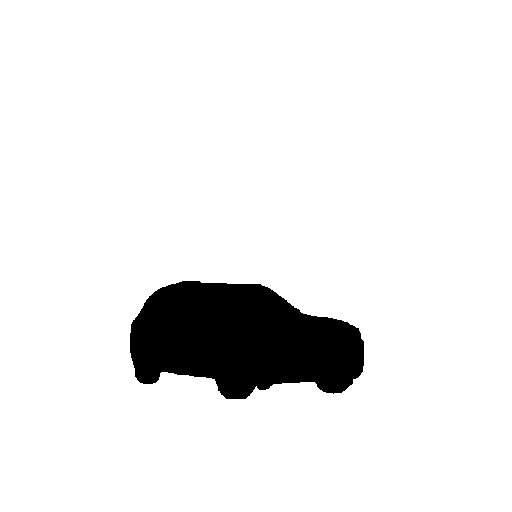

In [49]:
transformed_image_mask = transform(image=np.array(init_image), mask=np.array(anti_mask))
input_image = to_image(transformed_image_mask["image"])
input_mask = to_image(transformed_image_mask["mask"])
input_mask

In [ ]:
# Find the contours and centroid of the mask
contours, ret = find_contour(transformed_image_mask["mask"])
cx, cy = get_centroid(contours[0])
max_min_cy = (contours[0][:, 0, 1].max() - contours[0][:, 0, 1].min()) // 3

In [ ]:
anchor_point = int(np.random.uniform(0, max_min_cy))
anti_mask = np.copy(transformed_image_mask["mask"])
anti_mask[(cy - anchor_point):, :, :] = 0
anti_mask_lower = 255 - (transformed_image_mask["mask"] - anti_mask)

In [ ]:
to_image(anti_mask_lower)

In [ ]:
anti_mask = np.copy(transformed_image_mask["mask"])
anti_mask[:(cy - anchor_point), :] = 0
anti_mask_upper = 255 - (transformed_image_mask["mask"] - anti_mask)
anti_mask_upper = Image.fromarray(255 - anti_mask_upper).filter(ImageFilter.GaussianBlur(4))
new_mask_ori = Image.fromarray(transformed_image_mask["mask"])
new_mask = new_mask_ori.filter(ImageFilter.GaussianBlur(8))

anti_mask_upper

In [11]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
stable_inpainting_pipe = StableDiffusionInpaintPipeline.from_pretrained(model_id_inpainting, revision='fp16', torch_dtype=torch.float16)
stable_refiner_pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(model_id_refiner, variant='fp16', torch_dtype=torch.float16)

text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

In [56]:
characteristics = [
    "Dubai",
    "Christmas theme",
    "high res",
    "realistic",
    "correct reflections and shadows",
    "no watermark",
    "don't alter the subject's silhouette"
]

prompt = ",".join(characteristics)
with torch.no_grad():
    stable_inpainting_pipe = stable_inpainting_pipe.to(cuda)
    image = stable_inpainting_pipe(prompt=prompt, image=input_image, mask_image=input_mask, guidance_scale=10).images[0]
    # stable_inpainting_pipe = stable_inpainting_pipe.to(cpu)
    print("Done 👍")

  0%|          | 0/50 [00:00<?, ?it/s]

Done 👍


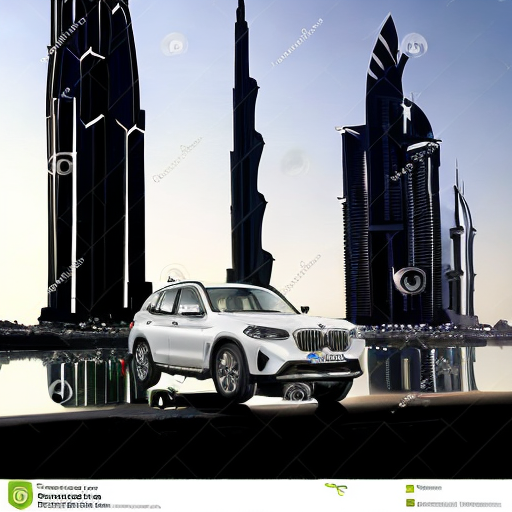

In [57]:
image